#Importing Necesseties

In [ ]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
#nltk.download ('popular')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from statistics import mean

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Generating Random Colours.

In [ ]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

#Read the data

In [ ]:
train = pd.read_csv('/content/Bangla_train.csv')
test = pd.read_csv('/content/Bangla_test.csv')
#ss = pd.read_csv('sample_submission.csv')
text, sentiment = list(train['text']), list(train['sentiment'])

In [ ]:
print(train.shape)
print(test.shape)

(677, 4)
(1006, 3)


In [ ]:
train.info()
train.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             676 non-null    float64
 1   text           677 non-null    object 
 2   selected_text  677 non-null    object 
 3   sentiment      677 non-null    object 
dtypes: float64(1), object(3)
memory usage: 21.3+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1006 non-null   int64 
 1   text       1006 non-null   object
 2   sentiment  1006 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.7+ KB


#EDA

In [ ]:
train.head()

,id,text,selected_text,sentiment
0,1498.0,হ্যা রুশনা ইন্টারমিডিয়েটে পড়ে কিন্তু ও বাচ্চা ...,হ্যা ও বাচ্চা একটা মেয়ে,positive
1,149.0,"খারাপ দিন আসতেই পারে,, হারি জিতি টাইকারদের সাথ...",হারি জিতি টাইকারদের সাথেই আছি,positive
2,1617.0,স্যার ধন্যবাদ আপনাকে,স্যার ধন্যবাদ আপনাকে,positive
3,98.0,চাপ না নিয়ে যার যার দায়িত্ব নিয়ে স্বাভাবিক খেল...,"স্বাভাবিক খেলাটা খেললেই হবে। জয়, পরাজয় কিনবা ড...",positive
4,122.0,"সৌভাগ্যবশত আমরা BBQ সালমন, সাগর বাস এবং ক্রিস্...",সৌভাগ্যবশত,positive


In [ ]:
train.describe()

,id
count,676.000000
mean,1900.329882
std,1387.056314
min,1.000000
25%,300.250000
50%,1904.500000
75%,2647.250000
max,5163.000000


In [ ]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,249
0,negative,217
2,positive,210


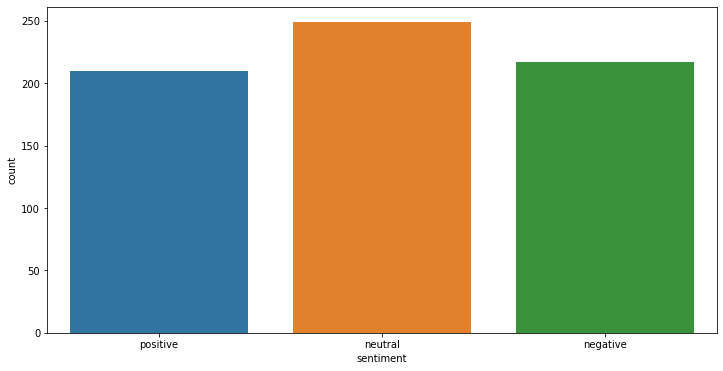

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

#Generating  Meta-Features

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [ ]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [ ]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [ ]:
train.head()

,id,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,1498.0,হ্যা রুশনা ইন্টারমিডিয়েটে পড়ে কিন্তু ও বাচ্চা ...,হ্যা ও বাচ্চা একটা মেয়ে,positive,0.555556,5,9,4
1,149.0,"খারাপ দিন আসতেই পারে,, হারি জিতি টাইকারদের সাথ...",হারি জিতি টাইকারদের সাথেই আছি,positive,0.555556,5,9,4
2,1617.0,স্যার ধন্যবাদ আপনাকে,স্যার ধন্যবাদ আপনাকে,positive,1.000000,3,3,0
3,98.0,চাপ না নিয়ে যার যার দায়িত্ব নিয়ে স্বাভাবিক খেল...,"স্বাভাবিক খেলাটা খেললেই হবে। জয়, পরাজয় কিনবা ড...",positive,0.666667,10,17,7
4,122.0,"সৌভাগ্যবশত আমরা BBQ সালমন, সাগর বাস এবং ক্রিস্...",সৌভাগ্যবশত,positive,0.083333,1,12,11


In [ ]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

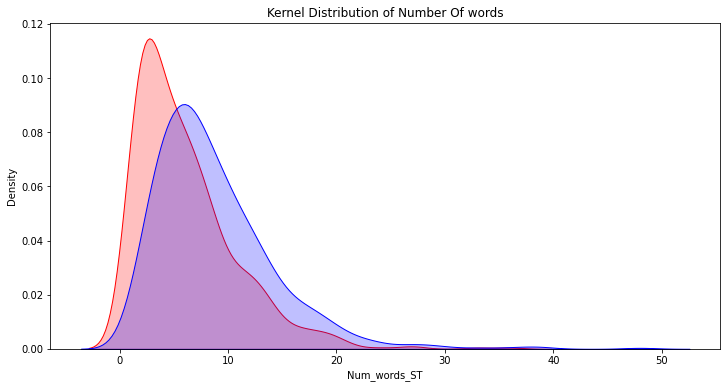

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

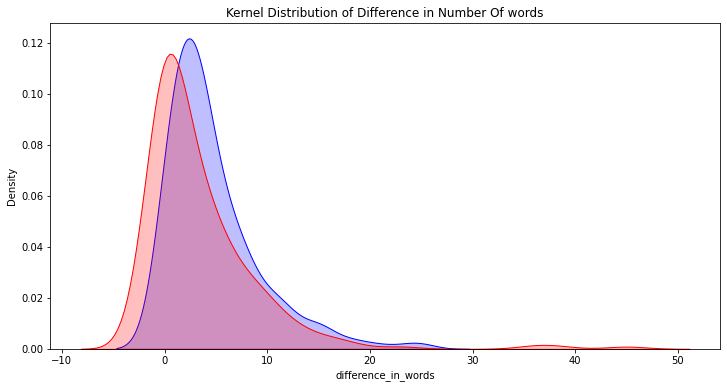

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

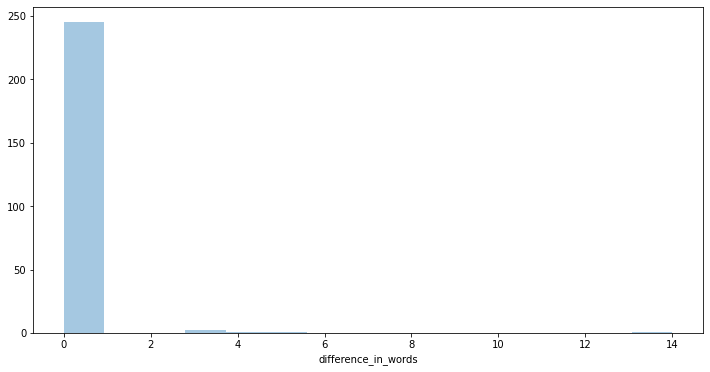

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

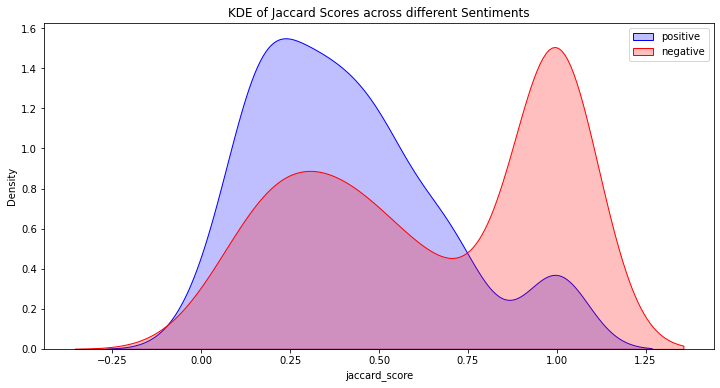

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

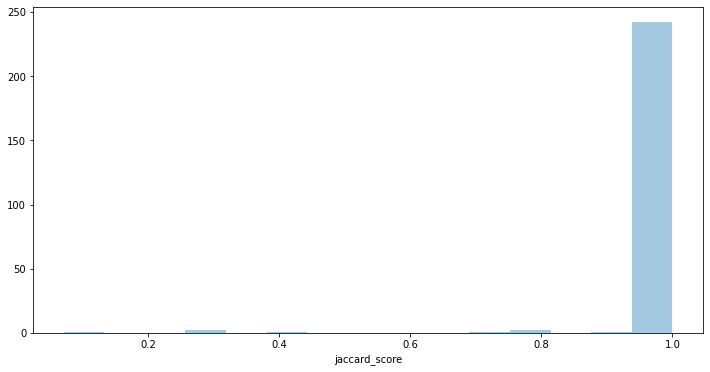

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

We can see some interesting trends here:
* Positive and negative sentences have high kurtosis and thus values are concentrated in two regions narrow and high density 
* Neutral sentences have a low kurtosis value and their is bump in density near values of 1

For those who don't know :
* Kurtosis is the measure of how peaked a distribution is and how much spread it is around that peak
* Skewness measures how much a curve deviates from a normal distribution

# Conclusion Of EDA

* We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1 .That means there is a cluster of sentences where there is a high similarity between text and selected texts ,if we can find those clusters then we can predict text for selected texts for those sentences irrespective of segment

Let's see if we can find those clusters,one interesting idea would be to check tweets which have number of words lesss than 3 in text, because there the text might be completely used as text

In [ ]:
k = train[train['Num_word_text']<=2]

In [ ]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.571429
neutral     1.000000
positive    0.755556
Name: jaccard_score, dtype: float64

k[k['sentiment']=='positive']

#Cleaning the code

In [ ]:
def preprocess(textdata):
    processedText = []
    # Defining regex patterns.
    
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for text in textdata:
        '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.'''
        text = str(text).lower()
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        #text = re.sub('\w*\d\w*', '', text)
        tweet = re.sub(sequencePattern, seqReplacePattern, text)
            
        processedText.append(tweet)
        
    return processedText

In [ ]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 0 seconds


#Most common words sentiment wise

word cloud for positive, negative and neutral tweets.

In [ ]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,না,47
1,আমি,43
2,এবং,39
3,ভাল,38
4,কি,33
5,জন্য,31
6,এই,30
7,একটি,28
8,আমার,27
9,করে,25


In [ ]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,ভাল,28
1,এবং,14
2,",",12
3,খুব,10
4,ধন্যবাদ,9
5,একটি,9
6,ভালো,9
7,চমৎকার,8
8,ছিল,7
9,জায়গা,7


In [ ]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,করে,12
2,কি,11
3,এই,9
4,সব,8
5,জন্য,8
6,আমাদের,7
7,ব্যাটিং,6
8,দিয়ে,6
9,খেলা,6
10,সাব্বির,6


In [ ]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

,Common_words,count
1,এবং,24
2,আমার,24
3,এই,20
4,কি,20
5,জন্য,18
6,আমরা,16
7,একটি,15
8,না,13
9,।,13
10,কিছু,12


In [ ]:
train['text'] = train['text'].apply(lambda x:preprocess(x))
train['selected_text'] = train['selected_text'].apply(lambda x:preprocess(x))

In [ ]:
train.head()

,id,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,temp_list
0,1498.0,"[হ, ্, য, া, , র, ু, শ, ন, া, , ই, ন, ্, ট, ...","[হ, ্, য, া, , ও, , ব, া, চ, ্, চ, া, , এ, ...",positive,0.555556,5,9,4,"[হ্যা, ও, বাচ্চা, একটা, মেয়ে]"
1,149.0,"[খ, া, র, া, প, , দ, ি, ন, , আ, স, ত, ে, ই, ...","[হ, া, র, ি, , জ, ি, ত, ি, , ট, া, ই, ক, া, ...",positive,0.555556,5,9,4,"[হারি, জিতি, টাইকারদের, সাথেই, আছি]"
2,1617.0,"[স, ্, য, া, র, , ধ, ন, ্, য, ব, া, দ, , আ, ...","[স, ্, য, া, র, , ধ, ন, ্, য, ব, া, দ, , আ, ...",positive,1.000000,3,3,0,"[স্যার, ধন্যবাদ, আপনাকে]"
3,98.0,"[চ, া, প, , ন, া, , ন, ি, য়, ে, , য, া, র, ...","[স, ্, ব, া, ভ, া, ব, ি, ক, , খ, ে, ল, া, ট, ...",positive,0.666667,10,17,7,"[স্বাভাবিক, খেলাটা, খেললেই, হবে।, জয়,, পরাজয়, ..."
4,122.0,"[স, ৌ, ভ, া, গ, ্, য, ব, শ, ত, , আ, ম, র, া, ...","[স, ৌ, ভ, া, গ, ্, য, ব, শ, ত, ]",positive,0.083333,1,12,11,[সৌভাগ্যবশত]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  3069


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


#evaluate model function

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Neutral','Negative','Positive']
    group_names = ['True New','False NNeg', 'False NPos','False NNeu','True Neg','False Pos','False PNew','False Neg','True Pos']
    group_percentages = ['{0:.4%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)


    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    

##NB Bernouli

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        12
     neutral       0.39      1.00      0.57        13
    positive       0.00      0.00      0.00         9

    accuracy                           0.38        34
   macro avg       0.13      0.33      0.19        34
weighted avg       0.15      0.38      0.22        34



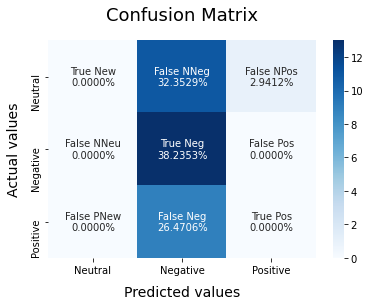

In [ ]:
BNBmodel = BernoulliNB(alpha = 3)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

##Linear SVC model

              precision    recall  f1-score   support

    negative       0.60      0.50      0.55        12
     neutral       0.40      0.31      0.35        13
    positive       0.36      0.56      0.43         9

    accuracy                           0.44        34
   macro avg       0.45      0.45      0.44        34
weighted avg       0.46      0.44      0.44        34



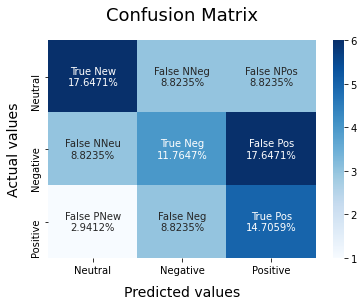

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

##Logistic Regression Model

              precision    recall  f1-score   support

    negative       0.60      0.50      0.55        12
     neutral       0.40      0.31      0.35        13
    positive       0.36      0.56      0.43         9

    accuracy                           0.44        34
   macro avg       0.45      0.45      0.44        34
weighted avg       0.46      0.44      0.44        34



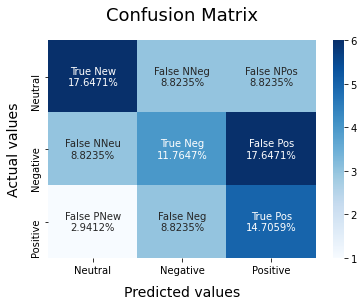

In [ ]:
LRmodel = LogisticRegression(C = 3, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

##Random Forest

              precision    recall  f1-score   support

    negative       0.50      0.50      0.50        12
     neutral       0.18      0.15      0.17        13
    positive       0.27      0.33      0.30         9

    accuracy                           0.32        34
   macro avg       0.32      0.33      0.32        34
weighted avg       0.32      0.32      0.32        34



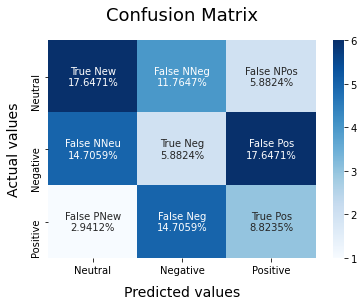

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier()
RFmodel.fit(X_train, y_train)
model_Evaluate(RFmodel)

#Final Model

In [ ]:
import pickle
file = open('/content/vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('/content/LRmodel.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('/content/BNBmodel.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('/content/RFmodel.pickle','wb')
pickle.dump(RFmodel, file)
file.close()

In [ ]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    # Load the vectoriser.
    file = open('/content/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('/content/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    # Load the RFmodel.
    file = open('/content/RFmodel.pickle', 'rb')
    RFmodel = pickle.load(file)
    file.close()

    return vectoriser, LRmodel , RFmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1,2], ["Negative","Positive","Neutral"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["স্পষ্টভাবে এটি রেস্টুরেন্ট!",
            "না!",
            "অসাধারন একটা নাটক??",
            "আমার মন খারাপ",
            "ঠিক আছে",
            "ও!"]
    
    df = predict(vectoriser, LRmodel, text)
    print (df)

                          text sentiment
0  স্পষ্টভাবে এটি রেস্টুরেন্ট!  positive
1                          না!  negative
2          অসাধারন একটা নাটক??   neutral
3                আমার মন খারাপ  negative
4                      ঠিক আছে  positive
5                           ও!  negative
